In [1]:
import sys
sys.path.append("../")

from Models.model_sources.markov_source import MarkovChain
from Models.MMC import MMC
from Models.DBN import FMC
import requests
from Models.model_sources.mtd_source import MTD
from Models.model_sources.path_encoder import PathEncoder, SequenceCutter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [12]:
interval = "5m"
symbol = "AAPL.US"
def get_crypto_price(symbol, exchange,interval, start_date = None):
    api_key = '630d712fd8bd74.01254339'
    api_url = f'https://eodhistoricaldata.com/api/intraday/{symbol}?api_token={api_key}&interval={interval}&fmt=json'
    print(requests.get(api_url).content)

    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df)
    df['close'] = df['close'].astype(float)
    return df
df = get_crypto_price(symbol = symbol, exchange = 'USD', interval = interval)
df = df.drop(["gmtoffset", "datetime", "timestamp","volume"], axis=1)
df['Change'] = df['close'].diff()
# go for 100 states
# add volume, increase to 24 states
# fix training data for MTD


"""
df['ma5'] = df['close'].rolling(window=5, min_periods=5).mean()
df['ma8'] = df['close'].rolling(window=8, min_periods=8).mean()
df['ma13'] = df['close'].rolling(window=13, min_periods=13).mean()
"""

b'[{"timestamp":1661175000,"gmtoffset":0,"datetime":"2022-08-22 13:30:00","open":169.690002,"high":169.86,"low":168.929992,"close":169.039993,"volume":5157485},{"timestamp":1661175300,"gmtoffset":0,"datetime":"2022-08-22 13:35:00","open":169.050003,"high":169.220001,"low":168.86,"close":169.029998,"volume":1400427},{"timestamp":1661175600,"gmtoffset":0,"datetime":"2022-08-22 13:40:00","open":169.039993,"high":169.262298,"low":168.61,"close":169.11,"volume":1731185},{"timestamp":1661175900,"gmtoffset":0,"datetime":"2022-08-22 13:45:00","open":169.11,"high":169.121093,"low":168.580001,"close":168.625,"volume":1504923},{"timestamp":1661176200,"gmtoffset":0,"datetime":"2022-08-22 13:50:00","open":168.625,"high":168.916595,"low":168.482604,"close":168.865005,"volume":1310750},{"timestamp":1661176500,"gmtoffset":0,"datetime":"2022-08-22 13:55:00","open":168.86,"high":169.100006,"low":168.850906,"close":168.949996,"volume":977068},{"timestamp":1661176800,"gmtoffset":0,"datetime":"2022-08-22 1

"\ndf['ma5'] = df['close'].rolling(window=5, min_periods=5).mean()\ndf['ma8'] = df['close'].rolling(window=8, min_periods=8).mean()\ndf['ma13'] = df['close'].rolling(window=13, min_periods=13).mean()\n"

In [14]:
#df = pd.read_csv('inflation_data.csv')
#df['year'] = pd.to_numeric(df['year'])
#df = df[(df['year'] > 1821) & (df['year'] < 1999)]
#df['Change'] = df['inflation rate']


df['Change_enc'] = 'none'
std = df.std()['Change']

df.loc[df.Change < 0.0, 'Change_enc'] = "drop"
df.loc[df.Change > 0.0, 'Change_enc'] = "rise"

df.loc[df.Change <= -std, 'Change_enc'] = "big drop"
df.loc[df.Change <= -2*std, 'Change_enc'] = "bigger drop"
df.loc[df.Change >= std, 'Change_enc'] = "big rise"
df.loc[df.Change >= 2*std, 'Change_enc'] = "bigger rise"

#df.loc[df.Change <= -3*std, 'Change_enc'] = "biggest drop"
#df.loc[df.Change >= 3*std, 'Change_enc'] = "biggest rise"

#df['volume_bin'] = pd.qcut(df['volume'], q=6, labels=[i for i in range(6)])
#df['open_bin'] = pd.qcut(df['open'], q=4, labels=[i for i in range(4)])
#df['close_bin'] = pd.qcut(df['close'], q=4 , labels=[i for i in range(4)])


"""columns = ["close_bin","open_bin"] #"volume_bin"]

for c in columns:
    res = [None, None, None]
    res.extend([(df.iloc[i-1][c],df.iloc[i-2][c], df.iloc[i-3][c])  for i in range(3, len(df))])
    df[c+'_history'] = res
"""
#df.dropna(inplace=True)
df = df.reset_index()

#df['ma_cross'] = [[x for _,x in sorted(zip([row['ma5'],row['ma8'],row['ma13']],[0,1,2]))] for key,row in df.iterrows()]


/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_11469/3746651963.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df.std()['Change']


In [16]:
df['gain'] = df['Change'].clip(lower=0).round(2)
df['loss'] = df['Change'].clip(upper=0).abs().round(2)
df['gain'] = df['gain'].fillna(0)
df['loss'] = df['loss'].fillna(0)

window_length = 14
df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()
df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()

df['ma_cross'] =\
    ["".join([str(x) for _,x in sorted(zip([row['ma5'],row['ma8']],[0,1]))]) for key,row in df.iterrows()]

#df['ma_cross'] = [''.join([str(x) for _,x in sorted(zip([row['ma5'],row['ma8'],row['ma13']],[0,1,2]))]) for key,row in df.iterrows()]

df['ma_cross_new'] = [0] + [1 if df.iloc[i]['ma_cross'] != df.iloc[i-1]['ma_cross'] else 0 for i in range(1, len(df))]

KeyError: 'ma5'

In [33]:
df[['ma_cross', 'ma_cross_new']].head(50)

KeyError: "None of [Index(['ma_cross', 'ma_cross_new'], dtype='object')] are in the [columns]"

In [34]:
window_length = 14
# Get WMS averages
# try to get more data
#
# Average Gains
for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
    df['avg_gain'].iloc[i + window_length + 1] = \
        (df['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df['gain'].iloc[i + window_length + 1]) \
        / window_length
# Average Losses
for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
    df['avg_loss'].iloc[i + window_length + 1] = \
        (df['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df['loss'].iloc[i + window_length + 1]) \
        / window_length
# View initial results
print(df[window_length-1:window_length+5])

/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_96174/398393028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_gain'].iloc[i + window_length + 1] = \
/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_96174/398393028.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_loss'].iloc[i + window_length + 1] = \


    index  year  amount  inflation rate  Change    Change_enc  gain  loss  \
13     13  1813    1.27            0.20    0.20  biggest rise   0.2  0.00   
14     14  1814    1.40            0.10    0.10      big rise   0.1  0.00   
15     15  1815    1.22           -0.13   -0.13   bigger drop   0.0  0.13   
16     16  1816    1.12           -0.08   -0.08      big drop   0.0  0.08   
17     17  1817    1.06           -0.06   -0.06      big drop   0.0  0.06   
18     18  1818    1.01           -0.05   -0.05          drop   0.0  0.05   

    avg_gain  avg_loss  
13  0.039286  0.017143  
14  0.045000  0.017143  
15  0.041786  0.025204  
16  0.038801  0.029118  
17  0.036030  0.031324  
18  0.033456  0.032658  


In [27]:
# Calculate RS Values
df['rs'] = df['avg_gain'] / df['avg_loss']
df = df.iloc[30:]
def convert_rs(value):
    if value > .70:
        return 0
    if value < .30:
        return 1
    return 2

df['rs_state'] = [convert_rs(df['rs'].values[i]) for i in range(len(df))]

/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_96174/3583435095.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rs_state'] = [convert_rs(df['rs'].values[i]) for i in range(len(df))]


In [17]:
df

,level_0,index,open,high,low,close,Change,Change_enc,gain,loss,avg_gain,avg_loss
0,0,0,169.690002,169.860000,168.929992,169.039993,NaN,none,0.00,0.00,NaN,NaN
1,1,1,169.050003,169.220001,168.860000,169.029998,-0.009995,drop,0.00,0.01,NaN,NaN
2,2,2,169.039993,169.262298,168.610000,169.110000,0.080002,rise,0.08,0.00,NaN,NaN
3,3,3,169.110000,169.121093,168.580001,168.625000,-0.485000,big drop,0.00,0.49,NaN,NaN
4,4,4,168.625000,168.916595,168.482604,168.865005,0.240005,rise,0.24,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6516,6516,6516,135.095001,135.320007,135.029495,135.035003,-0.065003,drop,0.00,0.07,0.115000,0.025714
6517,6517,6517,135.020004,135.210006,134.800003,134.880004,-0.154999,drop,0.00,0.15,0.109286,0.036429
6518,6518,6518,134.869995,135.449996,134.610000,134.879898,-0.000106,drop,0.00,0.00,0.107143,0.036429
6519,6519,6519,134.869995,135.074996,134.449996,134.520004,-0.359894,drop,0.00,0.36,0.101429,0.062143


## Fit models

In [18]:
values = [df.Change_enc]

data_to_fit = np.array([''.join([str(v.values[i]) for v in values]) for i in range(len(df))])

order = 3

sc = SequenceCutter(order)
x, y = sc.transform(data_to_fit)

pe = PathEncoder(order)
pe.fit(x, y)

x_tr, y_tr = pe.transform(x, y)

In [19]:
len(np.unique(x_tr))

7

In [23]:
from Models.HMC import HMC
from sklearn.model_selection import train_test_split

div = round(len(x_tr)*.90)
#X_train, X_test, y_train, y_test = x_tr[div:, :], x_tr[:div, :], y_tr[div:], y_tr[:div]

amount_to_average = 100

sgo_type = "greedy"
methods = [MMC, FMC, HMC, MTD] #FMC]
types = [m.__name__ for m in methods]
mmc = None

master_res = []
for _ in range(amount_to_average):
    (X_train, X_test, y_train, y_test) = train_test_split(x_tr, y_tr)

    state_count = len(np.unique(X_train))

    args_training = {"X_train": X_train, "y_train": y_train}
    args_testing =   {"X_test": X_test, "y_test": y_test}
    results_training = []
    results_testing = []

    for m in methods:
        model = m(state_count, order=order)
        training = MarkovChain.calculate_time(model.train, args_training)
        testing = MarkovChain.calculate_time(model.test, args_testing)

        # Why did we do this just for MMC
        if False:
            mmc = model
            pred_res = []
            drop_indexes = [key for key,value in pe.label_dict_inverse.items() if "drop" in value]
            rise_indexes = [key for key,value in pe.label_dict_inverse.items() if "rise" in value]

            for lag in X_test:

                prob_values = mmc.cpt[mmc.find_high(lag, mmc.index_dict)]
                drop_prob = sum([prob_values[key] for key in drop_indexes])

                if drop_prob >= .5:
                    pred_res.append(drop_indexes[0])
                else:
                    pred_res.append(rise_indexes[0])
        else:
            pred_res = model.predict(X_test)

        #results_training.append(training[0])
        results_testing.append(testing[0])

        count = 0
        for i,p in enumerate(pred_res):
            """
            if "drop" in pe.label_dict_inverse[p] and "drop" in pe.label_dict_inverse[y_test[i]]:
                count += 1
            elif "rise" in pe.label_dict_inverse[p] and "rise" in pe.label_dict_inverse[y_test[i]]:
                count += 1
            """
            pass

        """
        print(count/len(pred_res))
        print(model.__class__.__name__)
        print(f"Training: {training}")
        print(f"Testing: {testing}")
        print("")"""

    master_res.append(results_testing)

print(types)
for i in range(len(master_res[0])):
    print(sum([master_res[j][i] for j in range(len(master_res))])/len(master_res))

#print(types)
#print(results_testing)

['MMC', 'FMC', 'HMC', 'MTD']
0.41420245398773003
0.41837423312883437
0.41765644171779137
0.42461349693251516


In [59]:
m.master_res

[[0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.4727272727272727],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.4727272727272727],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.5272727272727272],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.5454545454545454],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909],
 [0.4909090909090909,
  0.4909090909090909,
  0.509090909090909,
  0.509090909090909]]

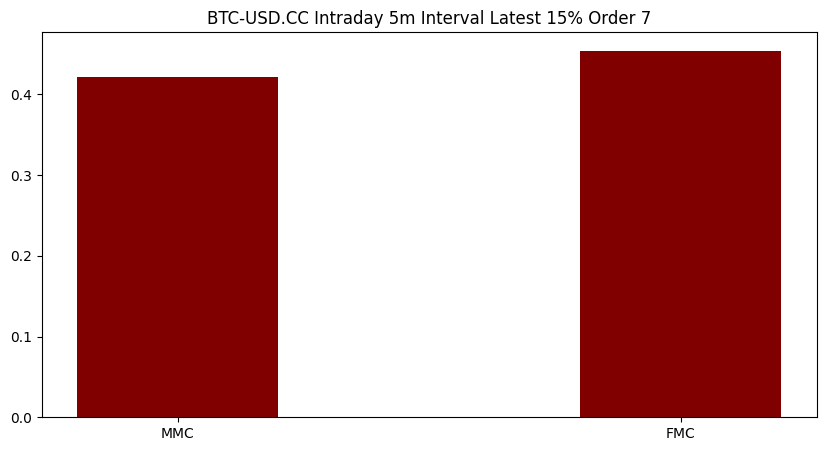

In [96]:
def create_bar_graph(data, title, types):
    plt.figure(figsize=(10, 5))

    # creating the bar plot
    plt.bar(types, data, color='maroon',
            width=0.4)

    plt.title(title)
    plt.show()
[m.__name__ for m in methods if m != MTD]

create_bar_graph(results_testing, f"{symbol} Intraday {interval} Interval Latest 15% Order {order}", [m.__name__ for m in methods if m != MTD])

In [37]:
[m.__name__ for m in methods]

['MMC', 'FMC', 'HMC']

## Choose model

In [39]:
mmc.predict([x_tr[-1]])

[0]